### Import Required Libraries


In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import confusion_matrix, classification_report
from typing import List, Tuple
import random


In [169]:
# Set the seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

### Load the dataset

In [170]:
df= pd.read_csv('./TVaritDoc.csv')

print(df.head(), "\n\n", "Shape:",df.shape)

                   timestamp           part_id  temperature_1  temperature_2  \
0  2024-02-15 05:44:34+05:30  2124077390649042          439.1          424.1   
1  2024-02-15 05:44:35+05:30  2124077390649042          438.9          423.9   
2  2024-02-15 05:44:36+05:30  2124077390649042          438.7          423.6   
3  2024-02-15 05:44:37+05:30  2124077390649042          438.4          423.4   
4  2024-02-15 05:44:38+05:30  2124077390649042          438.2          423.2   

   temperature_3  temperature_4  label  
0          536.0          518.6      0  
1          535.9          518.7      0  
2          535.6          518.9      0  
3          535.4          519.0      0  
4          535.2          519.2      0   

 Shape: (100000, 7)


In [171]:
df.columns

Index(['timestamp', 'part_id', 'temperature_1', 'temperature_2',
       'temperature_3', 'temperature_4', 'label'],
      dtype='object')

In [172]:
print("Checking for missing values", df.isnull().sum(), "\n\n")

print("Unique values in the label column: ", df.label.unique(), "\n\n")\

print("Number of different part ids: ", df.part_id.nunique(), "\n\n")

Checking for missing values timestamp        0
part_id          0
temperature_1    0
temperature_2    0
temperature_3    0
temperature_4    0
label            0
dtype: int64 


Unique values in the label column:  [0 1] 


Number of different part ids:  295 




<Axes: xlabel='timestamp'>

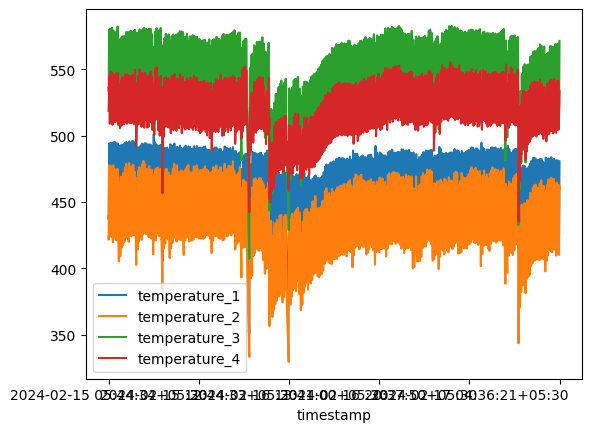

In [173]:
df.plot(x='timestamp', y=['temperature_1', 'temperature_2', 'temperature_3', 'temperature_4'])

### Prepare the dataset with required Features- Max, min, std

#### Aggregate the data by part_id column to generate features

In [174]:
grouped_df = df.groupby('part_id').agg({
    'temperature_1': ['std', 'max', 'min'],
    'temperature_2': ['std', 'max', 'min'],
    'temperature_3': ['std', 'max', 'min'],
    'temperature_4': ['std', 'max', 'min'],
    'label': 'first'  # Retain the label information, Assuming that the label is the same 
                    #for all rows of a part_id and doesnt change during the process
})

# Flatten the MultiIndex columns
grouped_df.columns = ['_'.join(col) for col in grouped_df.columns]

# Reset index if you want part_id to be a column
grouped_df = grouped_df.reset_index()
grouped_df.drop(columns=['part_id'], inplace=True)

# print(grouped_df)

#### Various plots for the features

#### Class imbalance check

Total number of labels:  295
Number of labels with value 0:  276
Number of labels with value 1:  19


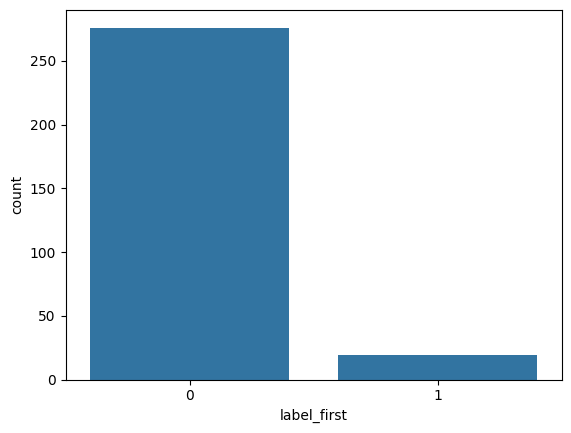

In [175]:
# Split the data into features and labels
countPlot = sns.countplot(x='label_first', data=grouped_df)
print("Total number of labels: ", grouped_df.label_first.count())
print("Number of labels with value 0: ", grouped_df.label_first.value_counts()[0])
print("Number of labels with value 1: ", grouped_df.label_first.value_counts()[1])

#### Violin Plot

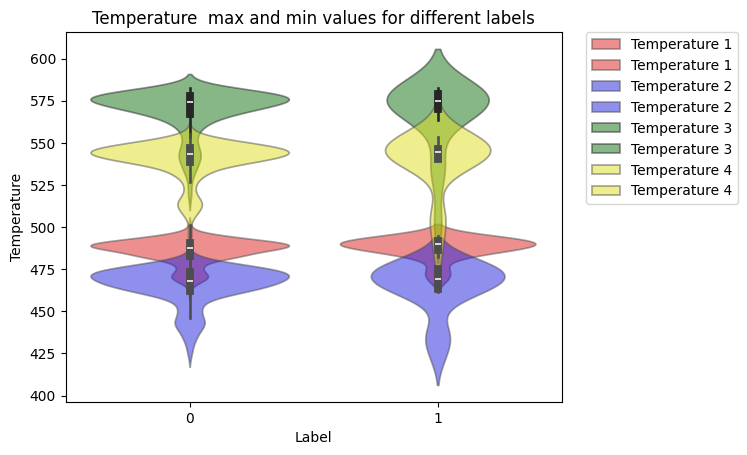

In [176]:
plot= sns.violinplot(x='label_first', y='temperature_1_max', data=grouped_df, alpha=0.5, legend=True, color='red', label='Temperature 1')

sns.violinplot(x='label_first', y='temperature_2_max', data=grouped_df, alpha=0.5, legend=True, color='blue', label='Temperature 2', ax=plot)

sns.violinplot(x='label_first', y='temperature_3_max', data=grouped_df, alpha=0.5, legend=True, color='green', label='Temperature 3', ax=plot)

sns.violinplot(x='label_first', y='temperature_4_max', data=grouped_df, alpha=0.5, legend=True, color='yellow', label='Temperature 4', ax=plot)

plot.set_title('Temperature  max and min values for different labels')
plot.set_ylabel('Temperature')
plot.set_xlabel('Label')
plot.legend(bbox_to_anchor=(1.05, 1),  borderaxespad=0.)


#### Box Plot

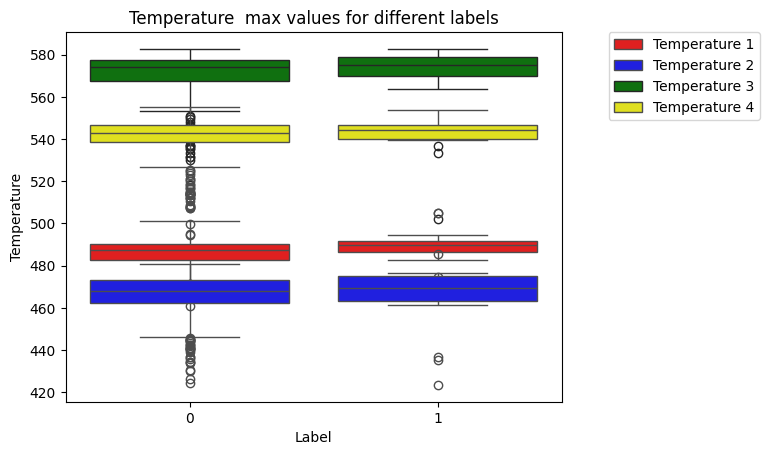

In [177]:
box_plot= sns.boxplot(x='label_first', y='temperature_1_max', data=grouped_df,  legend=True, color='red', label='Temperature 1')
sns.boxplot(x='label_first', y='temperature_2_max', data=grouped_df, legend=True, ax=box_plot, color='blue', label='Temperature 2')
sns.boxplot(x='label_first', y='temperature_3_max', data=grouped_df, legend=True, ax=box_plot, color='green', label='Temperature 3')
sns.boxplot(x='label_first', y='temperature_4_max', data=grouped_df, legend=True, ax=box_plot, color='yellow', label='Temperature 4')

box_plot.set_title('Temperature  max values for different labels')
box_plot.set_ylabel('Temperature')
box_plot.set_xlabel('Label')
box_plot.legend(loc='upper right', bbox_to_anchor=(1.4, 1), borderaxespad=0.)


### Prepare dataset for training

##### Define function to split the data into train and test

In [178]:


# Function to create windowed dataset
def create_windowed_dataset(dataset, window_size, batch_size, shuffle_buffer):
    """
    Creates a windowed dataset for time series classification.

    Args:
        dataset (pd.DataFrame): The input dataset.
        window_size (int): The size of the window.
        batch_size (int): The batch size.
        shuffle_buffer (int): The buffer size for shuffling.

    Returns:
        dataset (tf.data.Dataset): TF Dataset containing time windows.
    """
    
    
    dataset = tf.data.Dataset.from_tensor_slices(dataset)# Generate a TF Dataset from the series values
      
    
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)# Window the data but only take those with the specified size
      
    dataset = dataset.flat_map(lambda window: window.batch(window_size))# Flatten the windows by putting its elements in a single batch
    dataset = dataset.map(lambda window: (window[:, :-1], window[-1, -1]))# Assuming the last column is the label

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
      
    # Create batches of windows
    dataset = dataset.batch(batch_size)
      
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)
      
    return dataset

def split_dataset(split_ratio:int, data:pd.DataFrame, window_size:int, batch_size:int, shuffle_buffer:int) -> tf.data.Dataset:
    """_summary_

    Args:
        split_ratio (int): _description_
        data (pd.DataFrame): _description_
        window_size (int): _description_

    Returns:
        tf.data.Dataset: _description_
    """
    
    sr = split_ratio
    dataset_size = len(data)-window_size
    
    train_size = int(sr*dataset_size)
    
    return create_windowed_dataset(data[:train_size], window_size, batch_size, shuffle_buffer), create_windowed_dataset(data[train_size:], window_size, batch_size, shuffle_buffer)

In [179]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return np.float32(lr * tf.math.exp(-0.1))

##### Split the data into train and test using following Parameters

In [180]:
# Parameters
# Convert DataFrame to numpy array
data = grouped_df.values
window_size = 5
batch_size = 32
shuffle_buffer = 1000

In [181]:
train_dataset, test_dataset = split_dataset(0.8, data, window_size, batch_size, shuffle_buffer)

###### Preview the train and test data

In [182]:
for x, y in train_dataset.take(1):
    print(x.shape, y.shape)
    
for x, y in test_dataset.take(1):
    print(x.shape, y.shape)

(32, 5, 12) (32,)
(32, 5, 12) (32,)


2024-10-01 23:26:32.707023: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-01 23:26:32.725903: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Define the LSTM model and train the model

In [183]:
model = Sequential([
    LSTM(50, return_sequences=True,input_shape=(window_size, data.shape[1] - 1)),
    LSTM(20),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
hist1 = model.fit(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler)])

hist2 = model.fit(train_dataset, epochs=50, validation_data=test_dataset)


Epoch 1/50


/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9146 - loss: 0.4329 - val_accuracy: 0.9153 - val_loss: 0.3564 - learning_rate: 0.0010
Epoch 2/50
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8125 - loss: 0.4857

/opt/anaconda3/envs/dlLibraries/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9146 - loss: 0.3379 - val_accuracy: 0.9153 - val_loss: 0.3062 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.2975 - val_accuracy: 0.9153 - val_loss: 0.2908 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.2884 - val_accuracy: 0.9153 - val_loss: 0.2922 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.2927 - val_accuracy: 0.9153 - val_loss: 0.2970 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.2986 - val_accuracy: 0.9153 - val_loss: 0.3002 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.3021 - val_accuracy: 0.9153 - val_loss: 0.3013 - learning_rate: 0.0010
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.3033 - val_accuracy: 0.9153 - val_loss: 0.3010

In [184]:
# Plot the training history
print(hist1.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


#### Evaluate the model

In [185]:
#Plot Accuracy
def plot_loss(hist, ax):
    ax.plot(hist.history['loss'], label='Training Loss')
    ax.plot(hist.history['val_loss'], label='Validation Loss')
    ax.set_title("Loss vs. Epochs")
    ax.legend()

def plot_accuracy(hist,ax):
    ax.set_title('model accuracy')
    ax.set_ylabel('accuracy')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'], loc='upper left')
    ax.plot(hist.history['accuracy'])
    ax.plot(hist.history['val_accuracy'])
    
def plot_learning_rate(hist, ax):
    ax.plot(hist.history['learning_rate'])
    ax.set_title('Learning Rate vs. Epochs')
    ax.set_ylabel('Learning Rate')
    ax.set_xlabel('Epoch')
    
def plot_confusion_matrix(predictions, true_labels):
    """
    Plots the confusion matrix.

    Args:
        predictions (np.array): The predicted labels.
        true_labels (np.array): The true labels.
    """
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



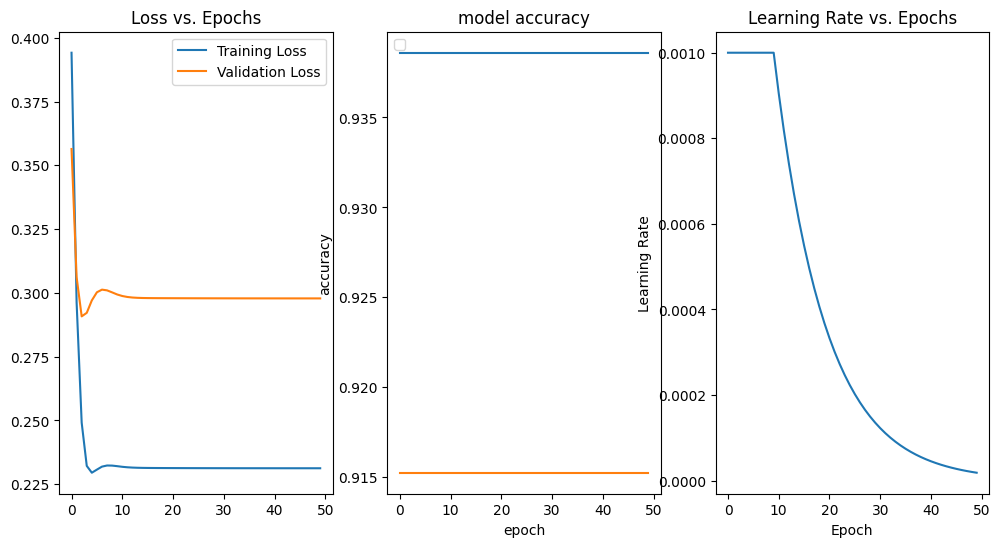

In [186]:
fig, (ax0, ax1,ax2) = plt.subplots(1, 3, figsize=(12, 6))
ax0 = plot_loss(hist1,ax0)
ax1 = plot_accuracy(hist1,ax1)
ax2 = plot_learning_rate(hist1,ax2)

In [187]:
print(hist2.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


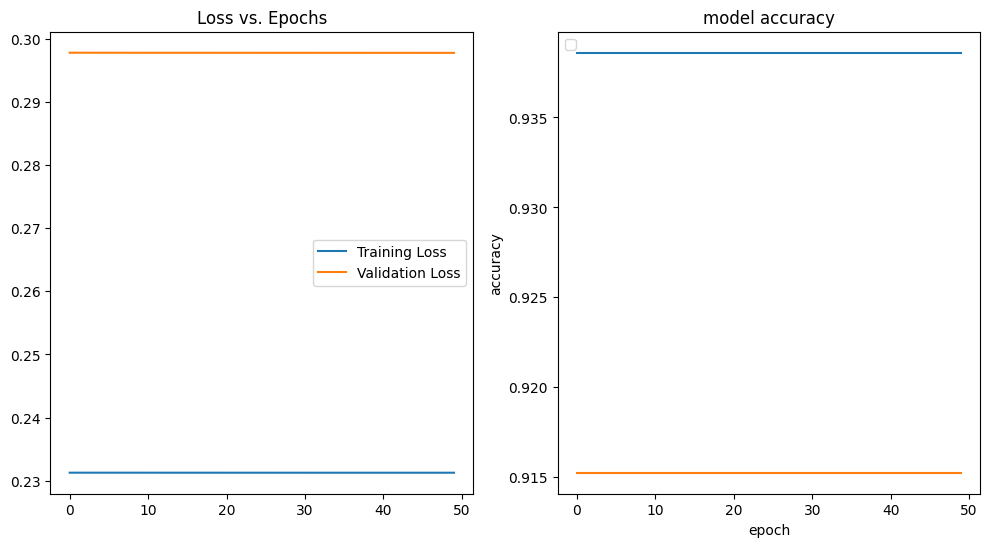

In [188]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0 = plot_loss(hist2,ax0)
ax1 = plot_accuracy(hist2,ax1)

In [189]:
predictions = model.predict(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        54
         1.0       0.00      0.00      0.00         5

    accuracy                           0.92        59
   macro avg       0.46      0.50      0.48        59
weighted avg       0.84      0.92      0.87        59



/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

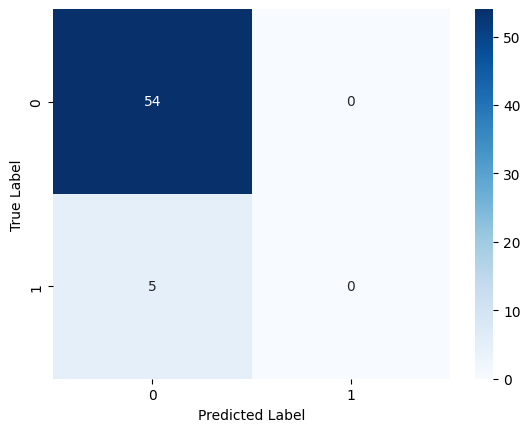

In [190]:
# Convert the predictions to binary
predictions = (predictions > 0.5).astype(int)

# Get the true labels
true_labels = np.array([label for _, label in test_dataset.unbatch()])

# Print the classification report
print(classification_report(true_labels, predictions))

plot_confusion_matrix(predictions, true_labels)


#### Define a CNN model and train the model

In [191]:
modelCNN = Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, data.shape[1] - 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

histCNN = model.fit(train_dataset, epochs=50, validation_data=test_dataset)


Epoch 1/50


/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


      1/Unknown 1s 1s/step - accuracy: 0.8125 - loss: 0.5908

/opt/anaconda3/envs/dlLibraries/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9146 - loss: 0.3012 - val_accuracy: 0.9153 - val_loss: 0.2947
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9146 - loss: 0.2967 - val_accuracy: 0.9153 - val_loss: 0.2956
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9146 - loss: 0.2975 - val_accuracy: 0.9153 - val_loss: 0.2969
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.2988 - val_accuracy: 0.9153 - val_loss: 0.2979
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.2998 - val_accuracy: 0.9153 - val_loss: 0.2984
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9146 - loss: 0.3004 - val_accuracy: 0.9153 - val_loss: 0.2986
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.3006 - val_accuracy: 0.9153 - val_loss: 0.2985
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.3006 - val_accuracy: 0.9153 - val_loss: 0.2984
Epoch 9/50
8/8 ━━━

2024-10-01 23:26:39.285614: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9146 - loss: 0.3002 - val_accuracy: 0.9153 - val_loss: 0.2981
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.3002 - val_accuracy: 0.9153 - val_loss: 0.2981
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.3002 - val_accuracy: 0.9153 - val_loss: 0.2981
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.3002 - val_accuracy: 0.9153 - val_loss: 0.2981
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.3002 - val_accuracy: 0.9153 - val_loss: 0.2981
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.3002 - val_accuracy: 0.9153 - val_loss: 0.2982
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.3002 - val_accuracy: 0.9153 - val_loss: 0.2982
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.3002 - val_accuracy: 0.9153 - val_loss: 0.2982
Epoch 19/50


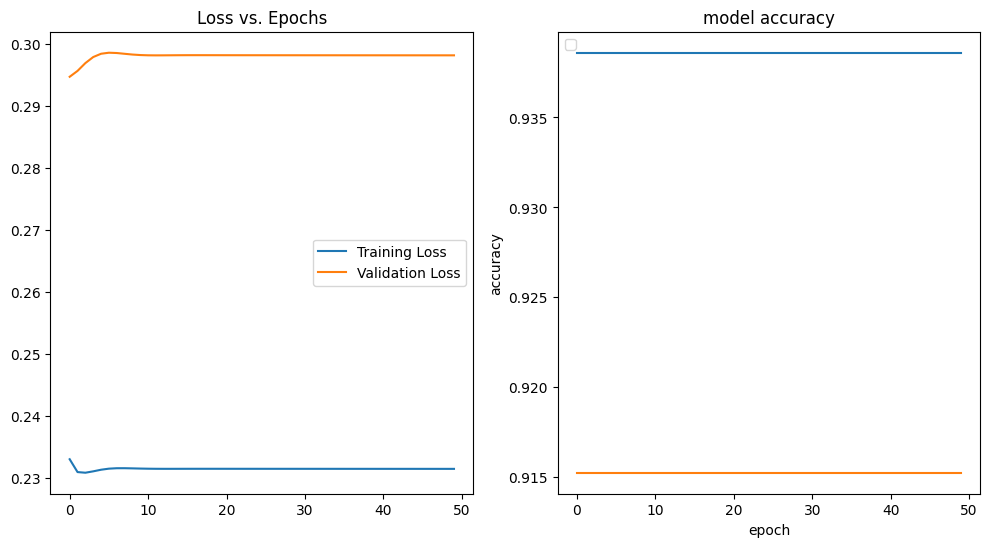

In [192]:
# Plot the training history
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0 = plot_loss(histCNN,ax0)
ax1 = plot_accuracy(histCNN,ax1)


#### Evaluate the model

In [193]:
predictionsCNN = model.predict(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        54
         1.0       0.00      0.00      0.00         5

    accuracy                           0.92        59
   macro avg       0.46      0.50      0.48        59
weighted avg       0.84      0.92      0.87        59



/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

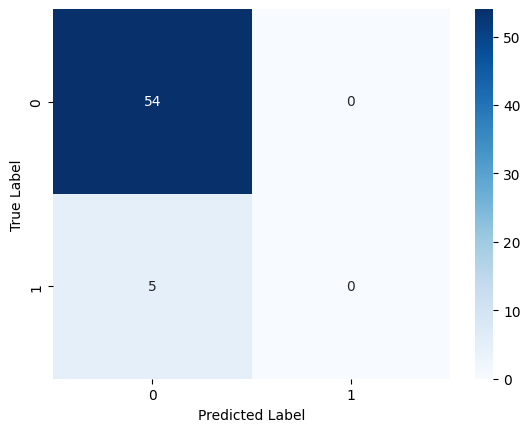

In [194]:
y_predCNN = (predictionsCNN > 0.5).astype(int)
y_trueCNN = np.array([label for _, label in test_dataset.unbatch()])

print(classification_report(y_trueCNN, y_predCNN))

plot_confusion_matrix(y_predCNN, y_trueCNN)

#### Resampling the dataset to make it balanced

In [195]:
### Resmaple the data to balance the classes

# Get the number of samples for each class
class_0 = grouped_df[grouped_df.label_first == 0]

class_1 = grouped_df[grouped_df.label_first == 1]

# Resample the data
class_0_resampled = class_0.sample(len(class_1), replace=True)
resampled_df = pd.concat([class_0_resampled, class_1], axis=0)

# Split the data into features and labels
data_resampled = resampled_df.values

train_dataset_resampled, test_dataset_resampled = split_dataset(0.8, data_resampled, window_size, batch_size, shuffle_buffer)



<Axes: xlabel='label_first', ylabel='count'>

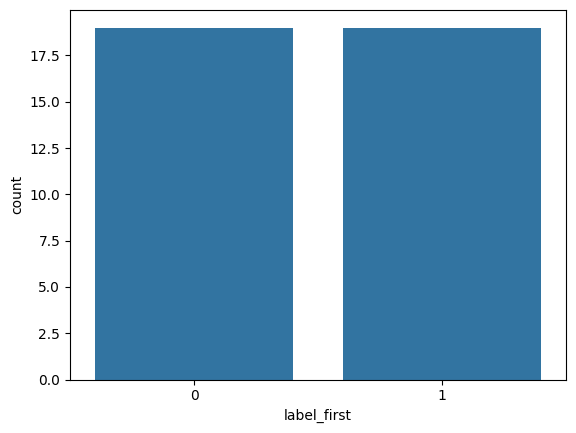

In [198]:
sns.countplot(data=resampled_df, x='label_first')

In [212]:
model_resampled = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window_size, data_resampled.shape[1] - 1)),
    LSTM(20),
    Dense(1, activation='sigmoid')
])

model_resampled.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

hist_resampled = model_resampled.fit(train_dataset_resampled, epochs=50, validation_data=test_dataset_resampled, callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler)])   

Epoch 1/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6818 - loss: 0.6309 - val_accuracy: 0.0000e+00 - val_loss: 0.9850 - learning_rate: 1.0000e-06
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6818 - loss: 0.6309 - val_accuracy: 0.0000e+00 - val_loss: 0.9850 - learning_rate: 1.0000e-06
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6818 - loss: 0.6309 - val_accuracy: 0.0000e+00 - val_loss: 0.9850 - learning_rate: 1.0000e-06
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6818 - loss: 0.6309

/opt/anaconda3/envs/dlLibraries/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6818 - loss: 0.6309 - val_accuracy: 0.0000e+00 - val_loss: 0.9850 - learning_rate: 1.0000e-06
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6818 - loss: 0.6309 - val_accuracy: 0.0000e+00 - val_loss: 0.9850 - learning_rate: 1.0000e-06
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6818 - loss: 0.6309 - val_accuracy: 0.0000e+00 - val_loss: 0.9850 - learning_rate: 1.0000e-06
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6818 - loss: 0.6309 - val_accuracy: 0.0000e+00 - val_loss: 0.9850 - learning_rate: 1.0000e-06
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6818 - loss: 0.6309 - val_accuracy: 0.0000e+00 - val_loss: 0.9850 - learning_rate: 1.0000e-06
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6818 - loss: 0.6309 - val_accuracy: 0.0000e+00 - val_loss: 0.9850 - learning_rate: 1.0000e-06
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6818 

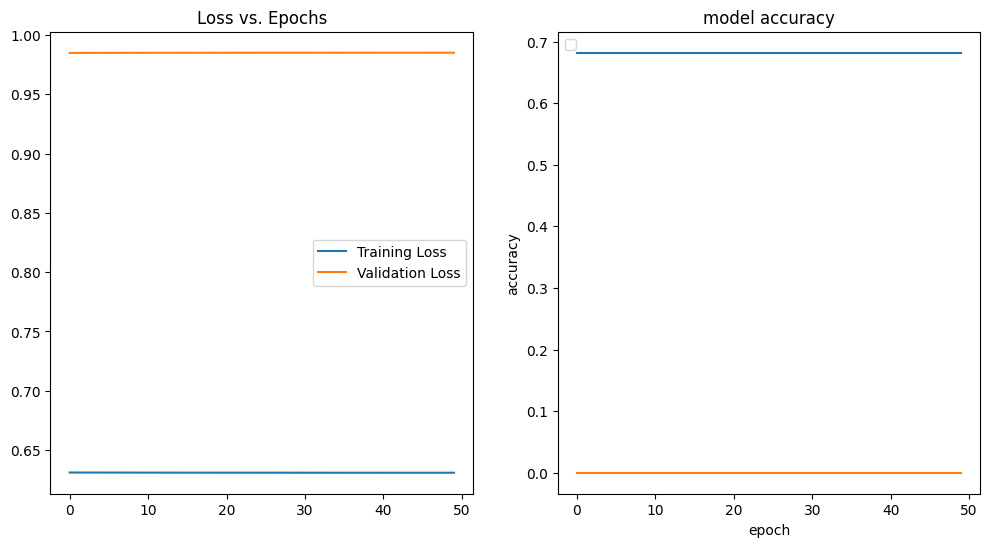

In [213]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

ax0 = plot_loss(hist_resampled,ax0)
ax1 = plot_accuracy(hist_resampled,ax1)

#### Evaluate the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00       8.0

    accuracy                           0.00       8.0
   macro avg       0.00      0.00      0.00       8.0
weighted avg       0.00      0.00      0.00       8.0



/opt/anaconda3/envs/dlLibraries/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dlLibraries/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/a

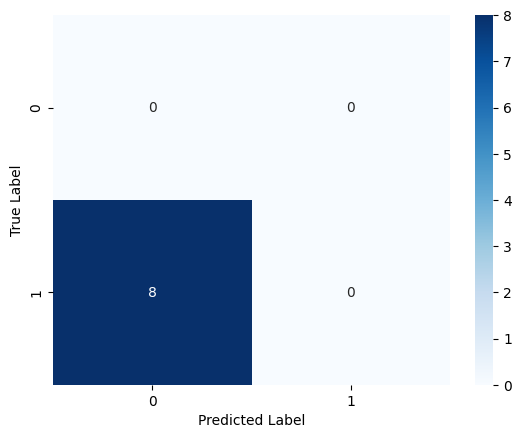

In [215]:
predictions_resampled = model_resampled.predict(test_dataset_resampled)

y_pred_resampled = (predictions_resampled > 0.5).astype(int)
y_true_resampled = np.array([label for _, label in test_dataset_resampled.unbatch()])

print(classification_report(y_true_resampled, y_pred_resampled))

plot_confusion_matrix(y_pred_resampled, y_true_resampled)